In [2]:
import sys
from functools import partial
from os.path import abspath
from typing import Optional, Union

if abspath("..") not in sys.path:
    sys.path.append(abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import colormaps

from flows4manufacturing.parameter_estimation.bayesflow import run_monte_carlo_sims
from flows4manufacturing.parameter_estimation.estimate import stepwise_model


In [2]:
def plot_sim_data(data, params: torch.Tensor):
    viridis = colormaps["jet"]
    min_params = params.min(0, keepdim=True)[0]
    max_params = params.max(0, keepdim=True)[0]
    colorp = (params - min_params) / (max_params - min_params)
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    colors = viridis(params.pow(2).sum(dim=-1).sqrt())
    for i, curve in enumerate(data):
        axs[0].plot(curve, color=colors[i], alpha=0.05)
    axs[0].grid()
    axs[0].set_ylim(-2, 2)
    axs[0].set_xlim(0, 24)
    axs[0].set_ylabel("Flank Wear (mm) [VB]")
    axs[0].set_xlabel("Run #")
    axs[1].scatter(params[:, 0], params[:, 1], color=colors, alpha=0.1)
    axs[1].grid()
    axs[1].set_ylabel("Param 2")
    axs[1].set_xlabel("Param 1")
    plt.show()


In [3]:
def stepwise_model(
    sim_steps: int,
    params: torch.Tensor,
    k0: int = 0,
    x0: Optional[Union[torch.Tensor, float]] = 0.0,
    noise_power: float = 0.0,
) -> torch.Tensor:
    a_vec = params[:, 0].reshape(-1, 1)
    b_vec = params[:, 1].reshape(-1, 1)
    sims = torch.zeros((params.shape[0], sim_steps), device=params.device)
    if x0 is not None:
        sims[:, 0] = x0
    for i in range(sim_steps - 1):
        k = k0 + i
        rate = 0.4 * b_vec * torch.exp(0.4 * a_vec * k)
        sims[:, i + 1] = sims[:, i] + rate.squeeze()
    sims += np.sqrt(noise_power) * torch.randn_like(sims)
    if x0 is not None:
        sims[:, 0] = x0
    return sims

tensor([ 0.1981, -0.0079, -0.0018,  ..., -0.5277, -0.0162, -0.0015])
33897
2000


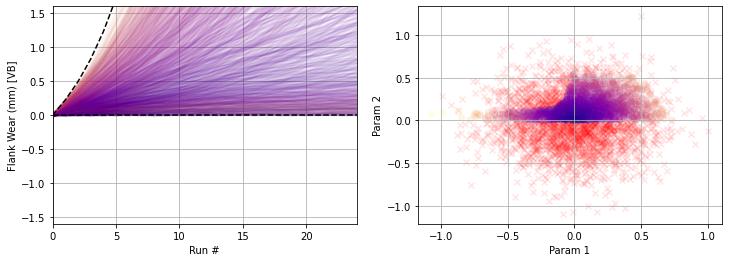

In [24]:
# Define the new priors
a_prior = torch.distributions.Normal(0.0, 0.3)
b_prior = torch.distributions.Normal(0.0, 0.3)
upper_bound = torch.exp(0.2 * torch.arange(25.0)) - 1
lower_bound = 0.0 * torch.arange(25.0)


def a_func(shape):
    return a_prior.sample(shape)


def b_func(shape):
    return b_prior.sample(shape)


# Create the simulated data set
sim_model = partial(stepwise_model, noise_power=0)
data, params = run_monte_carlo_sims(sim_model, 25, 100000, [a_func, b_func])

# Do data rejection
# Only keep increasing curves, within a tolerance
steps = data[:, 1:] - data[:, :-1]
second_diff = steps[:, 1:] - steps[:, :-1]
avg_second_diff = second_diff.mean(dim=-1)
step_mask = (avg_second_diff > -0.002)
print(avg_second_diff)
mask = ((data <= upper_bound) & (data >= lower_bound)).all(dim=-1) & step_mask
rejected_params = params[~mask]
data = data[mask]
params = params[mask]
print(len(data))

data = data[:2000]
params = params[:2000]
rejected_params = rejected_params[:2000]
print(len(data))

# NOW add noise
data += np.sqrt(0.0001) * torch.randn_like(data)

cmap = colormaps["plasma"]
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
colors = cmap(params.pow(2).sum(dim=-1).sqrt())
for i, curve in enumerate(data):
    axs[0].plot(curve, color=colors[i], alpha=0.03)
axs[0].grid()
axs[0].set_ylim(-1.6, 1.6)
axs[0].set_xlim(0, 24)
axs[0].set_ylabel("Flank Wear (mm) [VB]")
axs[0].set_xlabel("Run #")
axs[0].plot(upper_bound, color="k", ls="--")
axs[0].plot(lower_bound, color="k", ls="--")
axs[1].scatter(
    rejected_params[:, 0], rejected_params[:, 1], marker="x", color="red", alpha=0.1
)
axs[1].scatter(params[:, 0], params[:, 1], color=colors, alpha=0.1)
axs[1].grid()
axs[1].set_ylabel("Param 2")
axs[1].set_xlabel("Param 1")
plt.show()
